# Controlled question answering

This demo implements a simple form of question answering by using the basal ganglia to
store and retrieve information from working memory in response to visual input. More
specifically, the basal ganglia decides what to do with the information in the visual
channel based on its content (i.e. whether it is a statement or a question)

When you run the network, it will start by binding `RED` and `CIRCLE` and then binding
`BLUE` and `SQUARE` so the memory essentially has `RED * CIRCLE + BLUE * SQUARE`. It
does this because it is told that `RED * CIRCLE` is a STATEMENT (i.e. `RED * CIRCLE +
STATEMENT` in the code) as is `BLUE * SQUARE`. Then it is presented with something like
`QUESTION + RED` (i.e., "What is red?"). The basal ganglia then reroutes that input to
be compared to what is in working memory and the result shows up in the motor channel.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import nengo

import nengo_spa as spa

seed = 0

## Create the model

Notice that when you specify actions, you're determining which modules are connected to
which. For example, by having a mapping that depends on the state of cortex, you are
determining that the cortex and basal ganglia must be connected. As well, when you
specify that the result of the action changes the state of cortex, then you are
determining that thalamus must be connected to cortex.

In [2]:
def input_fn(t):
    if 0.1 < t < 0.3:
        return "STATEMENT+RED*CIRCLE"
    elif 0.35 < t < 0.5:
        return "STATEMENT+BLUE*SQUARE"
    elif 0.55 < t < 0.7:
        return "QUESTION+RED"
    elif 0.75 < t < 0.9:
        return "QUESTION+BLUE"
    else:
        return "0"


# Number of dimensions for the Semantic Pointers
dimensions = 128

# Number of neurons to represent each dimension
# Higher number for more accurate representation
n_per_dim = 100

# Make a model object with the SPA network
model = spa.Network(label="Controlled Question Answering", seed=seed)

with model:
    # Specify the modules to be used
    vision = spa.Transcode(input_fn, output_vocab=dimensions)
    motor = spa.State(dimensions, neurons_per_dimension=n_per_dim)
    memory = spa.State(
        dimensions, neurons_per_dimension=n_per_dim, feedback=1.0, feedback_synapse=0.1
    )

    # Transcode modules to show intermediate results
    statement = spa.Transcode(input_vocab=dimensions, output_vocab=dimensions)
    question = spa.Transcode(input_vocab=dimensions, output_vocab=dimensions)

    # Specify the action mapping
    with spa.ActionSelection() as action_sel:
        spa.ifmax(
            spa.dot(vision, spa.sym.STATEMENT),
            vision - spa.sym.STATEMENT >> statement,
            statement >> memory,
        )
        spa.ifmax(
            spa.dot(vision, spa.sym.QUESTION),
            vision - spa.sym.QUESTION >> question,
            ~(question) * memory >> motor,
        )

## Probe the output

In [3]:
with model:
    p_vision = nengo.Probe(vision.output, synapse=0.03)

    p_statement = nengo.Probe(statement.input, synapse=0.03)
    p_question = nengo.Probe(question.input, synapse=0.03)

    p_motor = nengo.Probe(motor.output, synapse=0.03)
    p_memory = nengo.Probe(memory.output, synapse=0.03)

    p_selected_actions = nengo.Probe(action_sel.thalamus.output, synapse=0.01)
    p_utility = nengo.Probe(action_sel.bg.input, synapse=0.01)

## Run the model

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(1.0)

## Plot the results

(0.0, 1.0)

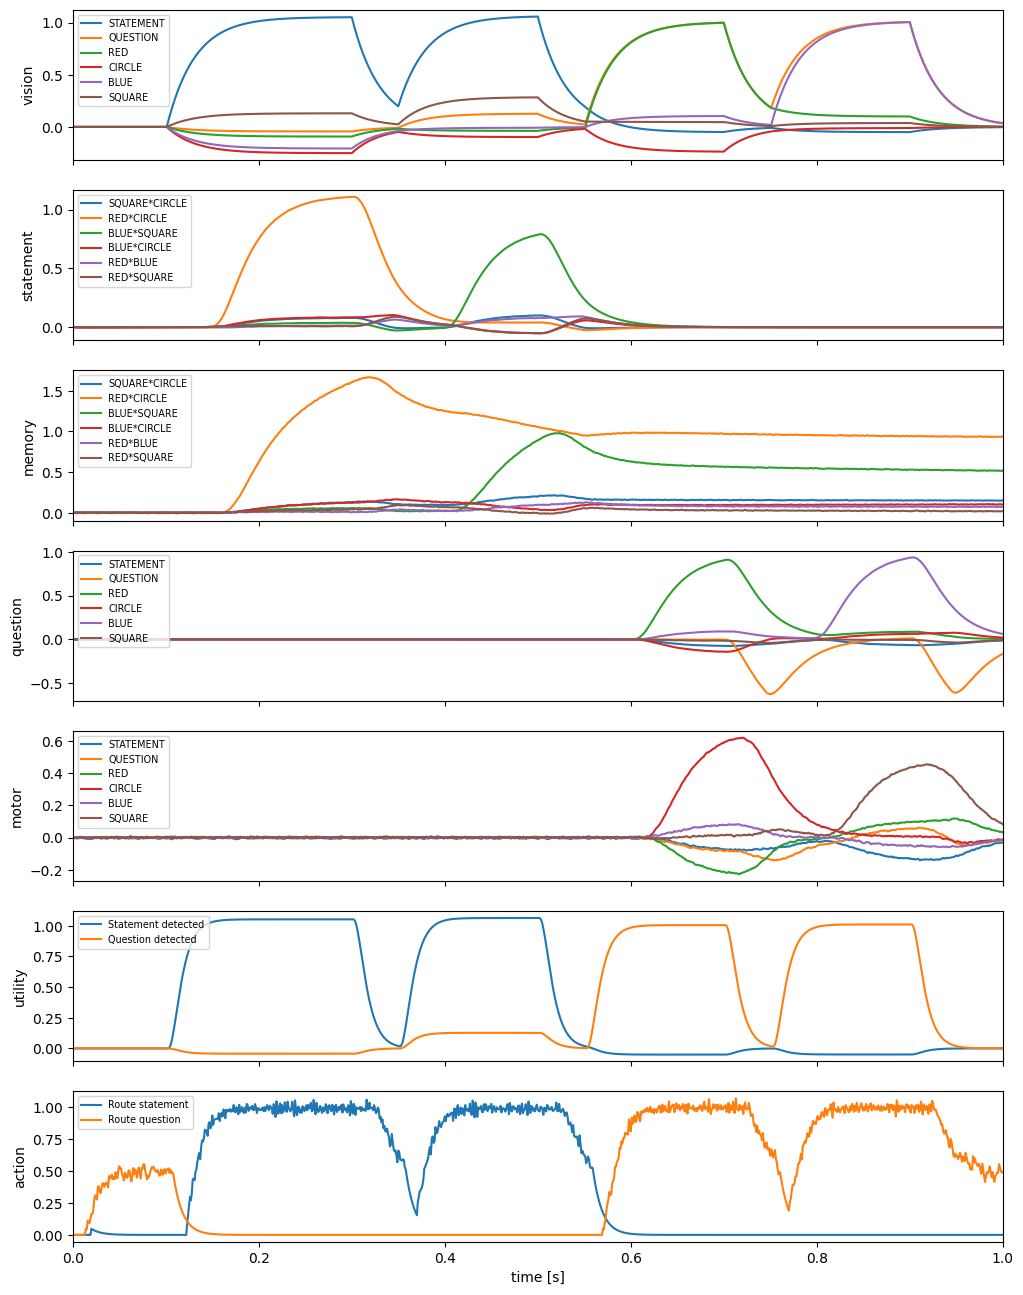

In [5]:
vocab = model.vocabs[dimensions]

fig, axes = plt.subplots(7, sharex=True, figsize=(12, 16))

axes[0].plot(sim.trange(), spa.similarity(sim.data[p_vision], vocab))
axes[0].legend(vocab.keys(), fontsize="x-small", loc="upper left")
axes[0].set_ylabel("vision")

attrs = ("RED", "BLUE", "SQUARE", "CIRCLE")
attr_vecs = vocab.create_subset(attrs)
attr_pairs = spa.pairs(attr_vecs)
attr_pair_vecs = [vocab.parse(p).v for p in attr_pairs]

axes[1].plot(sim.trange(), spa.similarity(sim.data[p_statement], attr_pair_vecs))
axes[1].legend(attr_pairs, fontsize="x-small", loc="upper left")
axes[1].set_ylabel("statement")

axes[2].plot(sim.trange(), spa.similarity(sim.data[p_memory], attr_pair_vecs))
axes[2].legend(attr_pairs, fontsize="x-small", loc="upper left")
axes[2].set_ylabel("memory")

axes[3].plot(sim.trange(), spa.similarity(sim.data[p_question], vocab))
axes[3].legend(vocab.keys(), fontsize="x-small", loc="upper left")
axes[3].set_ylabel("question")

axes[4].plot(sim.trange(), spa.similarity(sim.data[p_motor], vocab))
axes[4].legend(vocab.keys(), fontsize="x-small", loc="upper left")
axes[4].set_ylabel("motor")

axes[5].plot(sim.trange(), sim.data[p_utility])
axes[5].legend(
    ("Statement detected", "Question detected"), fontsize="x-small", loc="upper left"
)
axes[5].set_ylabel("utility")

axes[6].plot(sim.trange(), sim.data[p_selected_actions])
axes[6].legend(
    ("Route statement", "Route question"), fontsize="x-small", loc="upper left"
)
axes[6].set_ylabel("action")
axes[6].set_xlabel("time [s]")
axes[6].set_xlim((0, 1.0))